# GTFS Schedule
- Data: https://data.bus-data.dft.gov.uk/timetable/download/
- gtfs-kit: https://gitlab.com/mrcagney/gtfs_kit
- examples: https://gitlab.com/mrcagney/gtfs_kit/-/blob/master/notebooks/examples.ipynb
- docs:https://mrcagney.gitlab.io/gtfs_kit_docs/

## Imports

In [1]:
import warnings

import gtfs_kit as gk
import pandas as pd
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

## General

In [3]:
rids = {
    "1": "3815",
    "10": "4824",
    "5": "14187",
    "5A": "50065",
}
rids = {v:k for k, v in rids.items()}

## Load data and filter

Download one of the files from the bottom of the page here:

https://data.bus-data.dft.gov.uk/timetable/download/

In [4]:
path = "../data/itm_south_east_gtfs.zip"
feed = gk.read_feed(path, dist_units="mi")
# feed.validate()

In [5]:
agencies = [
    "OP376",  # oxford bus company
    "OP83",  # stagecoach oxfordshire
]
routes = ["5", "5A", "1", "10"]

In [6]:
cow = feed.routes[
    (feed.routes.agency_id.isin(agencies)) & (feed.routes.route_short_name.isin(routes))
]
cow

,route_id,agency_id,route_short_name,route_long_name,route_type
568,50065,OP376,5A,NaN,3
569,14187,OP376,5,NaN,3
921,4824,OP83,10,NaN,3
1413,3815,OP83,1,NaN,3


In [7]:
route_ids = cow.route_id.unique().tolist()
route_ids

['50065', '14187', '4824', '3815']

## Map

In [8]:
# feed.map_routes(["14187", "4824", "3815"], include_stops=True)

## Time series

In [9]:
dates = feed.get_first_week()[:5]
dates

['20221003', '20221004', '20221005', '20221006', '20221007']

In [10]:
trip_stats = feed.compute_trip_stats(route_ids=route_ids)
trip_stats.head(2)

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
512,VJ58713448d5f378462f099d9dce4881ea40b7e37f,14187,5,3,NaN,RPSP5bb474e47cb094f691802a7013ce93f78a4bd71f,35,04:50:00,05:21:00,340001230ERB,340000006R2,0,0.516667,NaN,NaN
1049,VJb6cffc25011e1e3fee18dcf6bfe52af29f5d693f,14187,5,3,NaN,RPSP5bb474e47cb094f691802a7013ce93f78a4bd71f,35,04:50:00,05:26:00,340001230ERB,340000006R2,0,0.600000,NaN,NaN


In [11]:
rts = feed.compute_route_time_series(trip_stats, dates, freq="1H")
rts.head(2)

indicator           num_trip_ends                 num_trip_starts            \
route_id                    14187 3815 4824 50065           14187 3815 4824   
datetime                                                                      
2022-10-03 00:00:00             0    0    0     0               0    0    0   
2022-10-03 01:00:00             0    0    0     0               0    0    0   

indicator                 num_trips       ... service_distance        \
route_id            50065     14187 3815  ...             4824 50065   
datetime                                  ...                          
2022-10-03 00:00:00     0         0    0  ...          4.01355   0.0   
2022-10-03 01:00:00     0         0    0  ...          0.00000   0.0   

indicator           service_duration                       service_speed  \
route_id                       14187      3815  4824 50065         14187   
datetime                                                                   
2022-10-03 00:00:00         0.366667  0.683333  0.25  0.15     15.893707   
2022-10-03 01:00:00         0.000000  0.000000  0.00  0.00      0.000000   

indicator                                      
route_id                  3815     4824 50065  
datetime                                       
2022-10-03 00:00:00  18.532127  16.0542   0.0  
2022-10-03 01:00:00   0.000000   0.0000   0.0  

[2 rows x 24 columns]

<AxesSubplot: xlabel='datetime'>

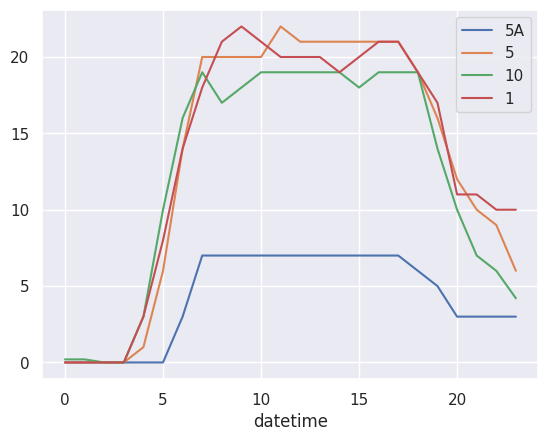

In [12]:
trips = rts.loc[:, (["num_trips"], route_ids)]
sns.set()
trips.columns = [rids[c[1]] for c in trips.columns]
trips.groupby(trips.index.hour).mean().plot()